# Iowa Liquor Sale Anlysis

In this project I have used sales data for year 2015 and first quarter of 2016 to build a model to predict the yearly sale of 2016.

In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Getting Data
The data is downloaded from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. The data is loaded with pandas into "iowa_ls_data" dataframe.

In [3]:
## Load the data into a DataFrame
iowa_ls_data = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")

# 2. Cleaning, Filtering and Reformating the Data

### 2.1 Removing inappropriate data entries.

In [4]:
iowa_ls_data = iowa_ls_data[iowa_ls_data['Zip Code'] != '712-2']

### 2.2 Filtering the data

2.2.1 Creating a categorical data column based on limited more general types of liquor

In [5]:
def majorCategory (x):
    x = str(x)
    if 'WHISKIES' in x or 'BOURBON' in x or ('SCOTCH' in x) or ('RYE' in x) or ('WHISKEY LIQUEUR' in x):
        return 'Whiskey'
    elif 'GINS' in x:
        return 'Gin'
    elif 'LIQUEURS' in x or 'AMARETTO' in x or 'CACAO' in x or 'MENTHE' in x or 'SCHNAPPS' in x:
        return 'Liqueur'
    elif 'RUM' in x:
        return 'Rum'
    elif 'TEQUILA' in x:
        return 'Tequila'
    elif 'VODKA' in x:
        return 'Vodka'
    elif 'TRIPLE SEC' in x or 'COCKTAILS' in x:
        return 'Cocktail'
    elif 'BRANDIES' in x:
        return 'Brandy'
    else:
        return 'Other'

In [6]:
iowa_ls_data['MajorCategory'] = iowa_ls_data['Category Name'].apply(majorCategory)

2.2.2 Keeping needed columns

In [7]:
cols = ["Date", "Store Number", "Zip Code", "Category Name", 
         "State Bottle Cost", "State Bottle Retail", "Bottles Sold", 
         "Sale (Dollars)", "Volume Sold (Liters)", "MajorCategory"]

In [8]:
filtered_iowa_ls_data = iowa_ls_data[cols]

### 2.3 Reformating Data

2.3.1 Reformating "Date" column from "object" type to "datetime" format

In [9]:
filtered_iowa_ls_data["Date"] = pd.to_datetime(filtered_iowa_ls_data["Date"], format="%m/%d/%Y")

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


2.3.2 Removing dollar sign from columns containing dollar values and converting them to "float"

In [10]:
cols_with_dollar = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]

for col in cols_with_dollar:
    filtered_iowa_ls_data[col] = filtered_iowa_ls_data[col].apply(lambda x: float(x[1:]))

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2.3.3 Droping rows with null values

In [11]:
filtered_iowa_ls_data.dropna()

,Date,Store Number,Zip Code,Category Name,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),MajorCategory
0,2015-11-04,3717,50674,APRICOT BRANDIES,4.50,6.75,12,81.00,9.00,Brandy
1,2016-03-02,2614,52807,BLENDED WHISKIES,13.75,20.63,2,41.26,1.50,Whiskey
2,2016-02-11,2106,50613,STRAIGHT BOURBON WHISKIES,12.59,18.89,24,453.36,24.00,Whiskey
3,2016-02-03,2501,50010,AMERICAN COCKTAILS,9.50,14.25,6,85.50,10.50,Cocktail
4,2015-08-18,3654,50421,VODKA 80 PROOF,7.20,10.80,12,129.60,21.00,Vodka
5,2015-04-20,2569,52402,AMERICAN DRY GINS,13.32,19.98,6,119.88,10.50,Gin
6,2015-08-05,2596,52501,AMERICAN GRAPE BRANDIES,6.66,9.99,3,29.97,2.25,Brandy
7,2015-06-25,3456,50428,CANADIAN WHISKIES,15.75,23.63,2,47.26,3.50,Whiskey
8,2016-01-04,4757,50035,IMPORTED VODKA,11.49,17.24,4,68.96,3.00,Vodka
9,2015-11-10,4346,52332,CINNAMON SCHNAPPS,7.62,11.43,2,22.86,2.00,Liqueur


2.3.4 Converting "MajorCategory" column to multiple dummy variable columns for each "MajorCategory" possible values

In [12]:
dummy_categories = pd.get_dummies(filtered_iowa_ls_data['MajorCategory'], prefix='Category')
iowa_ls_data_wd = pd.concat([filtered_iowa_ls_data, dummy_categories], axis = 1, join_axes=[dummy_categories.index])

2.3.5 Creating a dataframe to find stores which were open the whole 2015 year(good_stores), and then using that to filter the dataset.

In [13]:
iowa_data_dates = iowa_ls_data_wd.groupby(by=["Store Number"], as_index=False)
iowa_data_dates = iowa_data_dates.agg({"Date": [np.min, np.max]})
iowa_data_dates.columns = [' '.join(col).strip() for col in iowa_data_dates.columns.values]

In [14]:
iowa_data_stores = iowa_ls_data_wd.groupby(by="Store Number", as_index=False)
iowa_data_stores = iowa_data_stores.agg({"Date": [np.min, np.max]})
iowa_data_stores.columns = [' '.join(col).strip() for col in iowa_data_stores.columns.values]

lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")

mask = (iowa_data_stores["Date amin"] < lower_cutoff) & (iowa_data_stores["Date amax"] > upper_cutoff)
good_stores = iowa_data_stores[mask]["Store Number"]


In [15]:
iowa_filtered_data = iowa_ls_data_wd[iowa_ls_data_wd["Store Number"].isin(good_stores)]


# 3. Preparing Data for Analysis





### 3.1 Adding extra columns

In [16]:
iowa_filtered_data['Margin'] = (iowa_filtered_data['State Bottle Retail'] - iowa_filtered_data['State Bottle Cost']) * iowa_filtered_data['Bottles Sold']
iowa_filtered_data['$ per liter'] = iowa_filtered_data['Sale (Dollars)'] / iowa_filtered_data['Volume Sold (Liters)']

iowa_data_final = iowa_filtered_data

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### 3.2 Creating Target Vector

3.2.1 Extracting 2015 sales

In [18]:
iowa_filtered_data.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (iowa_filtered_data['Date'] >= start_date) & (iowa_filtered_data['Date'] <= end_date)
iowa_2015_store_data = iowa_filtered_data[mask]

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


3.2.2 Filtering the data and removing all the columns but the target sale column

In [20]:
iowa_2015_sales = iowa_2015_store_data[["Store Number", "Sale (Dollars)"]]

3.2.3 Grouping by each store and renaming the columns

In [21]:
iowa_2015_store_sales = iowa_2015_sales.groupby(by=["Store Number"], as_index=False)
iowa_2015_store_sales = iowa_2015_store_sales.agg({"Sale (Dollars)": np.sum})
iowa_2015_store_sales.columns = [''.join(col).strip() for col in iowa_2015_store_sales.columns.values]
iowa_2015_store_sales.columns = ['Store', 'SaleS']

3.2.4 Creatiny y_train vector

In [22]:
yearly_target_2015 = iowa_2015_store_sales["SaleS"]

### 3.3 Creating Feature Matrix

3.3.1 Extracting data for first quarter of 2015, grouped by each store to use as training features (X_train)

In [23]:
start_date_Q1 = pd.Timestamp("20150101")
end_date_Q1 = pd.Timestamp("20150401")
mask = (iowa_2015_store_data['Date'] >= start_date_Q1) & (iowa_2015_store_data['Date'] <= end_date_Q1)
iowa_Q1_2015_data = iowa_2015_store_data[mask]

iowa_Q1_2015_store_data = iowa_Q1_2015_data.groupby(by=['Store Number'], as_index=False)
iowa_Q1_2015_store_data = iowa_Q1_2015_store_data.agg({"Volume Sold (Liters)": [np.sum, np.mean],
                   "Sale (Dollars)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "$ per liter": np.mean,
                   "Zip Code": lambda x:int(x.iloc[0]),
                    "Category_Brandy": np.mean,
                    "Category_Rum": np.mean,
                    "Category_Tequila": np.mean,
                    "Category_Vodka": np.mean,
                    "Category_Whiskey": np.mean,
                    "Category_Cocktail": np.mean,
                    "Category_Liqueur": np.mean,
                    "Category_Other": np.mean,
                    "Category_Gin": np.mean                                         
                    })
iowa_Q1_2015_store_data.columns = [' '.join(col).strip() for col in iowa_Q1_2015_store_data.columns.values]

3.3.2 Renaming the columns

In [24]:
iowa_Q1_2015_store_data.columns = ['Store', 'Tequila', 'Rum', 'ppl', 'Vodka', 'Other', 'MarginS', 'MarginM', 'Cocktail', 'Q1SaleS', 'SaleM', 'Liqueur', 'ZipCode', 'Brandy', 'V_SoldS', 'V_SoldM', 'Whiskey', 'Gin']

3.3.3 Combine X_train matrix and y_train vector as a whole data set to use with statsmodel models

In [25]:
iowa_2015_store_model_data = pd.concat([iowa_Q1_2015_store_data, yearly_target_2015], axis=1, join_axes=[iowa_Q1_2015_store_data.index])

3.3.4 Extracting data for first quarter of 2016, grouped by each store to use as predicting features (X_test)

In [26]:
start_date_Q1_2016 = pd.Timestamp("20160101")
end_date_Q1_2016 = pd.Timestamp("20160401")
mask = (iowa_filtered_data['Date'] >= start_date_Q1_2016) & (iowa_filtered_data['Date'] <= end_date_Q1_2016)
iowa_Q1_2016_data = iowa_filtered_data[mask]

iowa_Q1_2016_store_sales = iowa_Q1_2016_data.groupby(by=['Store Number'], as_index=False)
iowa_Q1_2016_store_sales = iowa_Q1_2016_store_sales.agg({"Volume Sold (Liters)": [np.sum, np.mean],
                   "Sale (Dollars)": [np.sum, np.mean],
                   "Margin": [np.sum, np.mean],
                   "$ per liter": np.mean,
                   "Zip Code": lambda x:int(x.iloc[0]),
                    "Category_Brandy": np.mean,
                    "Category_Rum": np.mean,
                    "Category_Tequila": np.mean,
                    "Category_Vodka": np.mean,
                    "Category_Whiskey": np.mean,
                    "Category_Cocktail": np.mean,
                    "Category_Liqueur": np.mean,
                    "Category_Other": np.mean,
                    "Category_Gin": np.mean                                         
                    })
iowa_Q1_2016_store_sales.columns = [' '.join(col).strip() for col in iowa_Q1_2016_store_sales.columns.values]

3.3.5 Renaming the columns to match the training feature set

In [27]:
iowa_Q1_2016_store_sales.columns = ['Store', 'Tequila', 'Rum', 'ppl', 'Vodka', 'Other', 'MarginS', 'MarginM', 'Cocktail', 'Q1SaleS', 'SaleM', 'Liqueur', 'ZipCode', 'Brandy', 'V_SoldS', 'V_SoldM', 'Whiskey', 'Gin']

# 4. Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [30]:
iowa_2015_store_model_data.describe()

,Store,Tequila,Rum,ppl,Vodka,Other,MarginS,MarginM,Cocktail,Q1SaleS,SaleM,Liqueur,ZipCode,Brandy,V_SoldS,V_SoldM,Whiskey,Gin,SaleS
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1.161000e+03
mean,4147.530577,0.034530,0.137997,16.968481,0.273452,0.007617,1753.616770,40.006315,0.020962,5241.936305,119.541861,0.106197,51226.078381,0.053961,367.111938,8.739045,0.339371,0.025912,2.361038e+04
std,814.653125,0.049574,0.120689,4.980195,0.155947,0.019701,4052.880982,37.864352,0.038580,12134.971780,113.153631,0.096464,979.874389,0.083819,766.735985,7.379737,0.155839,0.039582,5.469956e+04
min,2106.000000,0.000000,0.000000,6.171429,0.000000,0.000000,15.940000,6.021552,0.000000,47.720000,18.043276,0.000000,50002.000000,0.000000,4.250000,0.765000,0.000000,0.000000,5.282400e+02
25%,3783.000000,0.000000,0.064516,14.111512,0.190476,0.000000,313.120000,24.110167,0.000000,937.860000,72.093333,0.000000,50316.000000,0.000000,67.780000,5.375000,0.258621,0.000000,3.984530e+03
50%,4364.000000,0.018868,0.118812,16.415796,0.252475,0.000000,657.000000,33.743571,0.000000,1970.460000,100.869000,0.100000,51023.000000,0.030457,145.500000,7.541892,0.333333,0.000000,8.596510e+03
75%,4726.000000,0.052632,0.187500,19.052056,0.333333,0.000000,1618.560000,47.087500,0.030303,4827.630000,140.377143,0.157895,52241.000000,0.076923,369.500000,9.960000,0.410959,0.042254,2.246676e+04
max,9010.000000,0.500000,1.000000,93.179310,1.000000,0.166667,69067.250000,818.285217,0.333333,207012.080000,2454.070435,1.000000,56201.000000,1.000000,13127.750000,120.913043,1.000000,0.500000,1.000783e+06


In [31]:
iowa_2015_store_model_data.corr()

,Store,Tequila,Rum,ppl,Vodka,Other,MarginS,MarginM,Cocktail,Q1SaleS,SaleM,Liqueur,ZipCode,Brandy,V_SoldS,V_SoldM,Whiskey,Gin,SaleS
Store,1.000000,-0.080032,0.041490,0.100884,0.099942,-0.060493,-0.346854,-0.000151,-0.250849,-0.346215,0.000185,-0.197478,0.021214,0.068608,-0.386278,-0.052728,0.078110,-0.116968,-0.354323
Tequila,-0.080032,1.000000,-0.067277,0.217955,-0.107447,0.027432,0.122038,0.002309,-0.017465,0.122195,0.002975,-0.029552,0.005200,0.042847,0.107157,-0.059581,-0.180921,0.072993,0.120662
Rum,0.041490,-0.067277,1.000000,-0.134486,-0.259647,-0.066214,-0.059091,-0.024179,-0.016434,-0.059174,-0.024070,-0.146071,-0.040937,-0.175398,-0.053626,-0.004462,-0.267072,-0.113993,-0.060571
ppl,0.100884,0.217955,-0.134486,1.000000,-0.193481,-0.001346,0.116152,0.113315,-0.189932,0.116520,0.115484,0.087961,0.026818,0.237380,0.070588,-0.151911,0.073473,0.078849,0.115406
Vodka,0.099942,-0.107447,-0.259647,-0.193481,1.000000,-0.044976,-0.064160,-0.055625,-0.060424,-0.064078,-0.056281,-0.293267,-0.021060,-0.159740,-0.064912,0.020707,-0.444691,-0.128517,-0.061852
Other,-0.060493,0.027432,-0.066214,-0.001346,-0.044976,1.000000,0.087137,0.029887,0.055205,0.087028,0.029794,0.014140,0.017902,-0.005910,0.093316,0.037747,-0.062487,0.017283,0.086397
MarginS,-0.346854,0.122038,-0.059091,0.116152,-0.064160,0.087137,1.000000,0.430588,0.105175,0.999988,0.431081,0.148414,0.014045,-0.018861,0.987069,0.390599,-0.081567,0.133614,0.983097
MarginM,-0.000151,0.002309,-0.024179,0.113315,-0.055625,0.029887,0.430588,1.000000,0.040908,0.430077,0.999903,0.022671,0.003065,-0.038511,0.424401,0.891148,0.044898,0.084769,0.412838
Cocktail,-0.250849,-0.017465,-0.016434,-0.189932,-0.060424,0.055205,0.105175,0.040908,1.000000,0.104512,0.039283,0.011472,-0.004503,-0.096401,0.143027,0.132824,-0.142270,0.044205,0.108228
Q1SaleS,-0.346215,0.122195,-0.059174,0.116520,-0.064078,0.087028,0.999988,0.430077,0.104512,1.000000,0.430618,0.148454,0.014127,-0.018734,0.986616,0.389293,-0.081531,0.133538,0.983361


In [32]:
iowa_2015_store_model_data.dtypes

Store         int64
Tequila     float64
Rum         float64
ppl         float64
Vodka       float64
Other       float64
MarginS     float64
MarginM     float64
Cocktail    float64
Q1SaleS     float64
SaleM       float64
Liqueur     float64
ZipCode       int64
Brandy      float64
V_SoldS     float64
V_SoldM     float64
Whiskey     float64
Gin         float64
SaleS       float64
dtype: object

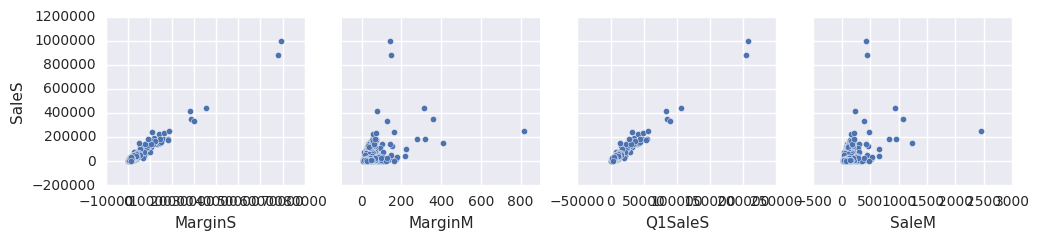

In [33]:
sns.pairplot(iowa_2015_store_model_data,x_vars=['MarginS', 'MarginM', 'Q1SaleS', 'SaleM'],y_vars=["SaleS"])

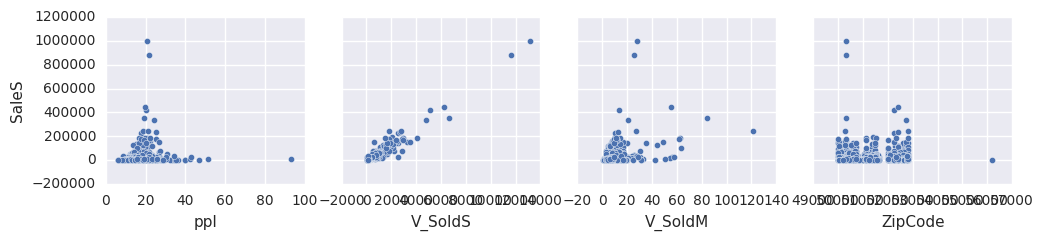

In [34]:
sns.pairplot(iowa_2015_store_model_data,x_vars=['ppl', 'V_SoldS', 'V_SoldM', 'ZipCode'],y_vars=["SaleS"])

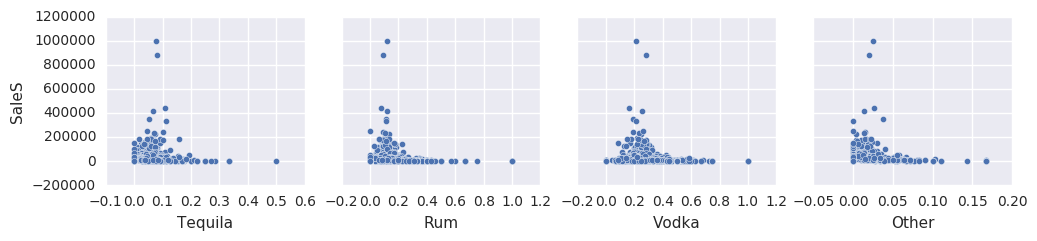

In [35]:
sns.pairplot(iowa_2015_store_model_data,x_vars=['Tequila', 'Rum', 'Vodka', 'Other'],y_vars=["SaleS"])

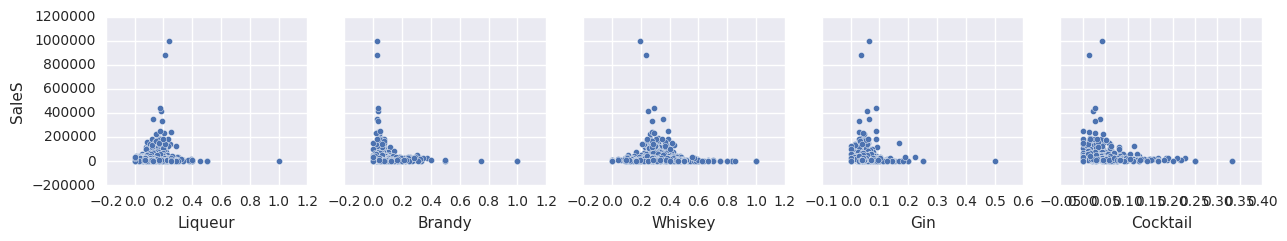

In [36]:
sns.pairplot(iowa_2015_store_model_data,x_vars=['Liqueur', 'Brandy', 'Whiskey', 'Gin', 'Cocktail'],y_vars=["SaleS"])

# 5. Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

### 5.1 Outliers
There seems to be couple of stores which have significantly different sale values, taking them out of model will fits the model better.

In [37]:
outlier_stores = list(iowa_2015_store_sales[iowa_2015_store_sales["SaleS"] > 600000]["Store"])
outlier_stores

[2633, 4829]

In [38]:
def remove_rows(df, col, values):
    mask = df[col].isin(values)
    df = df[~mask]
    return df

In [39]:
iowa_2015_store_model_data = remove_rows(iowa_2015_store_model_data, "Store", outlier_stores)
iowa_2015_store_sales = remove_rows(iowa_2015_store_sales, "Store", outlier_stores)
iowa_Q1_2016_store_sales = remove_rows(iowa_Q1_2016_store_sales, "Store", outlier_stores)
iowa_Q1_2015_store_data = remove_rows(iowa_Q1_2015_store_data, "Store", outlier_stores)
yearly_target_2015 = iowa_2015_store_sales["SaleS"]

### 5.2 Removing Obvious Features

In [40]:
X = iowa_Q1_2015_store_data.drop(["MarginS", "V_SoldS"], axis=1)

# 6. Building the models


### 6.1 Using sklearn

In [41]:
y = yearly_target_2015

In [42]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [43]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
print r2_score(model_lr.predict(X_train), y_train)
print r2_score(model_lr.predict(X_test), y_test)

0.944117365943
0.936623216385


In [44]:
print model_lr.coef_
print model_lr.score(X_test, y_test)

[ -1.22331625e+03   7.91646325e+01  -8.17590286e+01   7.69322339e+01
   1.72050603e+02   1.06653445e+02  -1.06499235e+05   8.46138870e+02
   3.75201033e+04   1.07626006e+05   9.02017959e+01   4.66589312e+02
  -4.08448625e+02  -7.89983235e+02  -3.09103838e+02   4.56552751e+02]
0.929942299224


In [45]:
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)
print r2_score(model_lasso.predict(X_train), y_train)
print r2_score(model_lasso.predict(X_test), y_test)

0.943117429304
0.933582852255


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [46]:
print model_lasso.coef_
print model_lasso.score(X_test, y_test)

[ -1196.49547806   -115.76388601   -584.12739409   -174.16113732
   -466.04490854     50.05877266   7649.05231945    611.17599447
  37649.64397274  -4888.41642906   -303.57528694    452.11810436
   -765.89968646  -2602.74467074  -1002.6254112     266.02272565]
0.926301251686


In [47]:
model_ridge = Lasso()
model_ridge.fit(X_train, y_train)
print r2_score(model_ridge.predict(X_train), y_train)
print r2_score(model_ridge.predict(X_test), y_test)

0.943141949817
0.933648169917


In [48]:
print model_ridge.coef_
print model_ridge.score(X_test, y_test)

[ -1.19638321e+03   3.95487455e+01  -2.01926568e+02  -1.69748109e+02
   2.56784238e+01   1.11250959e+02   6.15486692e+03   7.33450956e+02
   3.76482346e+04  -3.41676546e+03   0.00000000e+00   4.51426892e+02
  -5.00019840e+02  -2.57687126e+03  -5.09424796e+02   3.90519344e+02]
0.92637966515


### 6.2 Using StatsModel

In [49]:
data = iowa_2015_store_model_data

In [50]:
est = smf.ols("SaleS ~ C(ZipCode) + Rum + Brandy + Gin + Cocktail + Vodka + Whiskey + Liqueur + Tequila + Other + Q1SaleS",
              data).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SaleS   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     40.12
Date:                Fri, 13 Jan 2017   Prob (F-statistic):               0.00
Time:                        10:33:00   Log-Likelihood:                -12143.
No. Observations:                1159   AIC:                         2.505e+04
Df Residuals:                     775   BIC:                         2.700e+04
Df Model:                         383                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            1681.7849   7110.223      0.237      0.813     -1.23e+04  1.56e+04
C(ZipCode)[T.50003] -1773.8192   9654.772     -0.184      0.854     -2.07e+04  1.72e+04
C(ZipCode)[T.50006] -1782.9824   1.29e+04     -0.138      0.890     -2.72e+04  2.36e+04
C(ZipCode)[T.50009]  6571.1748   8264.005      0.795      0.427     -9651.312  2.28e+04
C(ZipCode)[T.50010]  -123.7110   7848.418     -0.016      0.987     -1.55e+04  1.53e+04
C(ZipCode)[T.50014] -5985.7908   9629.552     -0.622      0.534     -2.49e+04  1.29e+04
C(ZipCode)[T.50020]   603.5103   1.05e+04      0.057      0.954     -2.01e+04  2.13e+04
C(ZipCode)[T.50021] -1143.0583   8126.875     -0.141      0.888     -1.71e+04  1.48e+04
C(ZipCode)[T.50022]  3468.9690   8627.692      0.402      0.688     -1.35e+04  2.04e+04
C(ZipCode)[T.50023]  2679.4107   8278.933      0.324      0.746     -1.36e+04  1.89e+04
C(ZipCode)[T.50033]  2606.1749   1.29e+04      0.202      0.840     -2.28e+04   2.8e+04
C(ZipCode)[T.50035]  5756.7400   1.29e+04      0.445      0.656     -1.96e+04  3.11e+04
C(ZipCode)[T.50036] -1145.4528   8272.089     -0.138      0.890     -1.74e+04  1.51e+04
C(ZipCode)[T.50044]   935.7581   1.29e+04      0.072      0.942     -2.45e+04  2.64e+04
C(ZipCode)[T.50046]   843.7710   1.29e+04      0.065      0.948     -2.45e+04  2.62e+04
C(ZipCode)[T.50047] -7147.1021   1.29e+04     -0.554      0.580     -3.25e+04  1.82e+04
C(ZipCode)[T.50048]  2064.5930   1.29e+04      0.160      0.873     -2.33e+04  2.74e+04
C(ZipCode)[T.50049]  -720.8239   1.07e+04     -0.068      0.946     -2.17e+04  2.02e+04
C(ZipCode)[T.50054]  2310.8619   1.06e+04      0.219      0.827     -1.84e+04  2.31e+04
C(ZipCode)[T.50056]  3038.5222   1.29e+04      0.235      0.814     -2.23e+04  2.84e+04
C(ZipCode)[T.50058] -1847.1912    1.3e+04     -0.142      0.887     -2.74e+04  2.37e+04
C(ZipCode)[T.50060] -2079.8589   1.29e+04     -0.161      0.872     -2.74e+04  2.33e+04
C(ZipCode)[T.50069]  2492.4956   1.06e+04      0.235      0.814     -1.83e+04  2.33e+04
C(ZipCode)[T.50071]  1021.4272    1.3e+04      0.079      0.937     -2.44e+04  2.65e+04
C(ZipCode)[T.50072]   710.4320   1.29e+04      0.055      0.956     -2.46e+04  2.61e+04
C(ZipCode)[T.50075]  -580.4326   1.29e+04     -0.045      0.964     -2.59e+04  2.47e+04
C(ZipCode)[T.50076]  2741.9502   1.29e+04      0.212      0.832     -2.26e+04  2.81e+04
C(ZipCode)[T.50107] -1097.9493    1.3e+04     -0.084      0.933     -2.66e+04  2.44e+04
C(ZipCode)[T.50109]   741.9308   1.29e+04      0.057      0.954     -2.46e+04  2.61e+04
C(ZipCode)[T.50111]  5035.3578   8652.798      0.582      0.561      -1.2e+04   2.2e+04
C(ZipCode)[T.50112]  1371.9596   8489.320      0.162      0.872     -1.53e+04   1.8e+04
C(ZipCode)[T.50115]  1845.3844   1.29e+04      0.143      0.886     -2.35e+04  2.72e+04
C(Z

## 7. Predicting Sales for 2016



### 7.1  Using sklearn

In [51]:
X_16 = iowa_Q1_2016_store_sales.drop(["MarginS", "V_SoldS"], axis=1)


In [52]:
X_16 = scaler.transform(X_16)

In [53]:
y_16 = pd.DataFrame(model_lr.predict(X_16))
y_16.columns = ["Sale_2016"]

In [54]:
Sales_16 = pd.concat([iowa_Q1_2016_store_sales, y_16], axis=1, join_axes=[iowa_Q1_2016_store_sales.index])
Sales_16 = Sales_16[["Store", "Sale_2016"]]

In [55]:
Sales_15 = iowa_2015_store_sales
Sales_15.columns = ['Store', 'Sale_2015']

In [56]:
Store_sales = pd.merge(Sales_15, Sales_16, how='inner')
Store_sales.head()

,Store,Sale_2015,Sale_2016
0,2106,146326.22,135080.361702
1,2113,9310.22,13017.508314
2,2130,111871.43,124222.959174
3,2152,7721.08,9421.537165
4,2178,24324.18,28332.928412


### 7.2 Using StatsModel

In [57]:
data_16 = (iowa_Q1_2016_store_sales[["ZipCode", "Rum", "Brandy", "Gin",
            "Cocktail", "Vodka", "Whiskey", "Liqueur", "Tequila",
            "Other", "Q1SaleS"]])

In [61]:
Sale_2016_SM = pd.DataFrame(est.predict(data_16))
Sale_2016_SM.columns = ["Sale_2016"]

In [62]:
Sale_2016_SM = pd.concat([iowa_Q1_2016_store_sales, Sale_2016_SM], axis=1, join_axes=[iowa_Q1_2016_store_sales.index])
Sale_2016_SM = Sale_2016_SM[["Store", "Sale_2016"]]

In [63]:
Store_sales_SM = pd.merge(Sales_15, Sale_2016_SM, how='inner')
Store_sales.head()

,Store,Sale_2015,Sale_2016
0,2106,146326.22,135080.361702
1,2113,9310.22,13017.508314
2,2130,111871.43,124222.959174
3,2152,7721.08,9421.537165
4,2178,24324.18,28332.928412
